# Sentiment analysis with RNN

In [1]:
import numpy as np
import scipy.sparse
import json
import zipfile as zip

import spacy
from keras.preprocessing import text, sequence
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser

import keras.backend as K
from keras.utils import to_categorical
from keras import models, optimizers, regularizers
from keras.layers import Dropout, Dense, Activation, Flatten, LSTM, \
Conv1D, MaxPooling1D, GRU, Embedding, CuDNNLSTM, Bidirectional

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Importing

Data is preprocessed as a list of lists, reviews are parsed and stop words and punctuation are removed.

In [2]:
re_run = False

if re_run:
    # processed from gensim_walkthrough notebook
    with open('../../data/processed/processed.txt', 'r') as f:
        restaurants = tuple(json.loads(line) for line in f)

    # different text cleaning for reviews
    with open('../../data/processed/reviews_cleaned.txt', 'r') as f:
        reviews = tuple(json.loads(line) for line in f)

## Keras text processing example

In [3]:
if re_run:
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(reviews[0])
    tokenizer.word_index

## Doing the same process with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [3]:
%%time

if re_run:
    
    # create dictionary
    dict_yelp = corpora.Dictionary(reviews)
    # tune corpus to get a smaller dictionary and therefore a smaller doc_term matrix, 
    # embeddings will still work but bow will not fit into 8gb gpu otherwise
    dict_yelp.filter_extremes(no_below=10, keep_n=13000)
    dict_yelp.save('../../data/processed/dictionary')

else:
    
    dict_yelp = corpora.Dictionary.load('../../data/processed/dictionary')

print(len(dict_yelp))

13000
CPU times: user 1.19 ms, sys: 7.7 ms, total: 8.89 ms
Wall time: 7.88 ms


In [5]:
if re_run:
    # most common words
    top_ids = sorted(dict_yelp.dfs.items(), key=lambda x: x[1], reverse=True)[0:30]
    [(dict_yelp[item[0]], item[1]) for item in top_ids]

In [6]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys()) + 1
    
    for word in text:        
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_final)
    
    return processed[0:max_len]        

In [7]:
%%time

if re_run:
    
    corpus = tuple(text_sequencer(dict_yelp, review) for review in reviews)
    corpus = sequence.pad_sequences(corpus, maxlen=200)
    assert corpus.shape == (490049, 200)
    # this is the converted corpus array, not bow
    np.save('../../data/processed/corpus.npy', corpus)

else:
    corpus = np.load('../../data/processed/corpus.npy')

CPU times: user 2.26 s, sys: 482 ms, total: 2.74 s
Wall time: 2.75 s


## Integrating glove embeddings

In [4]:
def load_embeddings(emb_path = '/projects/embeddings/data/'):
    # load glove vectors
    embeddings_index={}
    with zip.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(keys, dict_yelp):
    
    embeddings_index = load_embeddings()
    conversion_table = {}
    for key in keys:
        if bytes(key, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[key]+1] = embeddings_index[bytes(key, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[key]+1] = np.random.randn(100)
    return conversion_table

In [5]:
%%time
conversion_table = id_to_glove(dict_yelp.token2id.keys(), dict_yelp)
embedding_matrix= np.vstack(conversion_table.values())
embedding_matrix = np.vstack((np.zeros(100), embedding_matrix, np.random.randn(100)))

CPU times: user 16.5 s, sys: 209 ms, total: 16.7 s
Wall time: 16.7 s


## Labels

In [10]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    elif rating in [1,2]:
        return 0
    else:
        return None
    
def get_rating_set(corpus, stars):
    
    
    mids = set()
    
    def get_mids():

        for i, rating in enumerate(stars):
            if rating is None:
                mids.add(i)
    
    get_mids()
    filtered_corpus, filtered_stars = [], []
    
    for i in range(len(corpus)):
        if i in mids:
            next
        else:
            filtered_corpus.append(corpus[i]), filtered_stars.append(stars[i])
    
    return filtered_corpus, filtered_stars

In [6]:
if re_run:
    stars = [convert_rating(restaurant['stars']) for restaurant in restaurants]
    data, lab = get_rating_set(corpus, stars)
    with open('../../data/numpy/ratings.npy', 'wb') as outf:
        np.save(outf, lab)
    with open('../../data/numpy/corpus.npy', 'wb') as outf:
        np.save(outf, data)
else:
    data, lab = np.load('../../data/numpy/corpus.npy'), np.load('../../data/numpy/ratings.npy')

In [7]:
train, val, train_y, val_y = train_test_split(data, lab, test_size = 0.2)

/home/ryeyoo/miniconda3/envs/keras/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


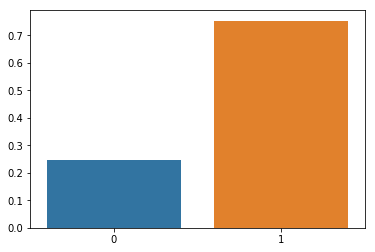

In [13]:
sns.barplot(x = lab, y = lab, estimator=lambda x: len(x)/len(lab))
plt.show()

## Modeling 

In [16]:
vocab_size = len(dict_yelp)
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [15]:
# units for output size in Dense layer, vocab_size for number of features in nlp in Embedding 
# tried adding dropout but it lowered accuracy, shouldn't need it if it's not overfitting
def get_model():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Conv1D(100, 5))
    model.add(Conv1D(100, 3))
    model.add(MaxPooling1D(4))
    model.add(LSTM(67))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

#model = get_model()

In [16]:
def get_model2():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(Bidirectional(CuDNNLSTM(67, return_sequences = True)))
    model.add(Bidirectional(CuDNNLSTM(67)))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [8]:
def get_model3():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    #model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(CuDNNLSTM(67))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
    model.summary()
    return model

In [ ]:
get_model3()

In [9]:
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

In [ ]:
?Input

In [10]:
import keras
import keras.backend as K
import tensorflow as tf


class ScaledDotProductAttention(keras.layers.Layer):
    """The attention layer that takes three inputs representing queries, keys and values.

    \text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V

    See: https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self,
                 return_attention=False,
                 history_only=False,
                 **kwargs):
        """Initialize the layer.

        :param return_attention: Whether to return attention weights.
        :param history_only: Whether to only use history data.
        :param kwargs: Arguments for parent class.
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.history_only = history_only
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'return_attention': self.return_attention,
            'history_only': self.history_only,
        }
        base_config = super(ScaledDotProductAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [input_shape[-1], input_shape[0][:2] + (input_shape[1][1],)]
        return input_shape[-1]

    def compute_mask(self, inputs, mask=None):
        if isinstance(mask, list):
            mask = mask[-1]
        if self.return_attention:
            return [mask, None]
        return mask

    def call(self, inputs, mask=None, **kwargs):
        query, key, value = inputs
        feature_dim = K.shape(query)[-1]
        e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(feature_dim, dtype=K.floatx()))
        if self.history_only:
            query_len, key_len = K.shape(query)[1], K.shape(key)[1]
            ones = tf.ones((query_len, key_len))
            e -= (ones - tf.matrix_band_part(ones, -1, 0)) * 1e9
        if isinstance(mask, list) and mask[-1] is not None:
            e -= (1.0 - K.cast(K.expand_dims(mask[-1], axis=-2), K.floatx())) * 1e9
        a = keras.activations.softmax(e)
        v = K.batch_dot(a, value)
        if self.return_attention:
            return [v, a]
        return v

In [11]:
import keras
import keras.backend as K
import tensorflow as tf


class SeqSelfAttention(keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.

        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf

        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e10)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.attention_activation = keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

        super(SeqSelfAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': keras.regularizers.serialize(self.kernel_initializer),
            'bias_initializer': keras.regularizers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'attention_activation': keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            inputs, positions = inputs
            positions = K.cast(positions, 'int32')
            mask = mask[1]
        else:
            positions = None

        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            ones = tf.ones((input_len, input_len))
            if self.history_only:
                local = tf.matrix_band_part(
                    ones,
                    K.minimum(input_len, self.attention_width - 1),
                    0,
                )
            else:
                local = tf.matrix_band_part(
                    ones,
                    K.minimum(input_len, self.attention_width // 2),
                    K.minimum(input_len, (self.attention_width - 1) // 2),
                )
            e = e * K.expand_dims(local, 0)
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1)
        s = K.tile(K.expand_dims(s, axis=-1), K.stack([1, 1, input_len]))
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if positions is not None:
            pos_num = K.shape(positions)[1]
            batch_indices = K.tile(K.expand_dims(K.arange(K.shape(inputs)[0]), axis=-1), K.stack([1, pos_num]))
            pos_indices = K.stack([batch_indices, positions], axis=-1)
            v = tf.gather_nd(v, pos_indices)
            a = tf.gather_nd(a, pos_indices)

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q, k = K.dot(inputs, self.Wt), K.dot(inputs, self.Wx)
        q = K.tile(K.expand_dims(q, 2), K.stack([1, 1, input_len, 1]))
        k = K.tile(K.expand_dims(k, 1), K.stack([1, input_len, 1, 1]))
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e = e + self.ba
        return e

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape, pos_shape = input_shape
            output_shape = (input_shape[0], pos_shape[1], input_shape[2])
        else:
            output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(inputs, list):
            mask = mask[1]
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - tf.eye(input_len))) / batch_size

    @staticmethod
    def get_custom_objects():
        return {'SeqSelfAttention': SeqSelfAttention}

In [12]:
import keras
from keras import backend as K


class SeqWeightedAttention(keras.layers.Layer):
    """Y = \text{softmax}(XW + b) X
    See: https://arxiv.org/pdf/1708.00524.pdf
    """

    def __init__(self, use_bias=True, return_attention=False, **kwargs):
        self.supports_masking = True
        self.use_bias = use_bias
        self.return_attention = return_attention
        self.W, self.b = None, None
        super(SeqWeightedAttention, self).__init__(** kwargs)

    def get_config(self):
        config = {
            'use_bias': self.use_bias,
            'return_attention': self.return_attention,
        }
        base_config = super(SeqWeightedAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=keras.initializers.get('uniform'))
        if self.use_bias:
            self.b = self.add_weight(shape=(1,),
                                     name='{}_b'.format(self.name),
                                     initializer=keras.initializers.get('zeros'))
        super(SeqWeightedAttention, self).build(input_shape)

    def call(self, x, mask=None):
        logits = K.dot(x, self.W)
        if self.use_bias:
            logits += self.b
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return input_shape[0], output_len

    def compute_mask(self, _, input_mask=None):
        if self.return_attention:
            return [None, None]
        return None

    @staticmethod
    def get_custom_objects():
        return {'SeqWeightedAttention': SeqWeightedAttention}

## Training

In [17]:
model = get_model3()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          1300200   
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, 200, 100)          6465      
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 67)                45292     
_________________________________________________________________
dense_5 (Dense)              (None, 31)                2108      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 32        
Total params: 1,354,097
Trainable params: 1,354,097
Non-trainable params: 0
_________________________________________________________________


In [14]:
def get_model3():
    model = models.Sequential()
    model.add(Embedding(len(embedding_matrix), 100, input_length=200,  embeddings_regularizer=regularizers.l2(1e-6), weights = [embedding_matrix]))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(CuDNNLSTM(67))
    model.add(Dense(31))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
    model.summary()
    return model

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [19]:
model.fit(train, train_y, batch_size=250, epochs=2, verbose=1, validation_split=0.2)

Train on 267212 samples, validate on 66804 samples
Epoch 1/2
267212/267212 [==============================] - 215s 806us/step - loss: 0.4491 - binary_crossentropy: 0.1972 - acc: 0.9197 - val_loss: 0.3351 - val_binary_crossentropy: 0.1579 - val_acc: 0.9375
Epoch 2/2
267212/267212 [==============================] - 216s 808us/step - loss: 0.2887 - binary_crossentropy: 0.1454 - acc: 0.9428 - val_loss: 0.2696 - val_binary_crossentropy: 0.1524 - val_acc: 0.9403


In [ ]:
# # reset weights if necessary
# model.reset_states()

In [23]:
# adjust lr since val loss increases, seems to be going past minimum
K.set_value(model.optimizer.lr, 0.0001)


In [24]:
model.fit(train, train_y, batch_size=500, epochs=1, verbose=1, validation_split=0.2)

Train on 267212 samples, validate on 66804 samples
Epoch 1/1
267212/267212 [==============================] - 15s 56us/step - loss: 0.9735 - binary_crossentropy: 0.5589 - acc: 0.7529 - val_loss: 0.9732 - val_binary_crossentropy: 0.5587 - val_acc: 0.7531


In [ ]:
if re_run:
    model.save('../../data/models/lstm.hdfs')
else:
    from keras.models import load_model
    model = load_model('../../data/models/lstm.hdfs')

## Evaluation

In [ ]:
print(model.metrics_names)
model.evaluate(val, val_y, batch_size=32, verbose=1)

In [ ]:
def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
   
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
        print('prob error is greater than 0.5 is %.4f' % cond_error)
        print('binary cross entropy is %.4f' % binary_cross_entropy)
    

In [ ]:
evaluate(val, val_y)